In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
% matplotlib inline
plt.style.reload_library()
plt.style.use('ggplot')
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 14
import numpy as np
import math
from scipy.ndimage.filters import gaussian_filter

Default maximum firing rate (2*e0):  5.0  Hz.
Default membrane potential threshold (v0):  -0.069  V.
Default sigmoid steepness (r):  560.0  Hz.


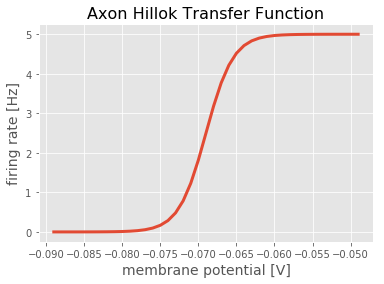

In [2]:
from core.axon import KnoescheAxon

# initialize axon
axon = KnoescheAxon()

# print default parameters (can be changed during initialization)
print('Default maximum firing rate (2*e0): ', axon.transfer_function_args['max_firing_rate'], ' Hz.')
print('Default membrane potential threshold (v0): ', axon.transfer_function_args['membrane_potential_threshold'], ' V.')
print('Default sigmoid steepness (r): ', axon.transfer_function_args['sigmoid_steepness'], ' Hz.')

# plot axon
fig, axes = plt.subplots()
axes = axon.plot_transfer_function(create_plot=False, axes=axes)

Default synaptic efficacies (He/Hi):  [3.8189999999999997e-13, -1.273e-12]  A.
Default synaptic rise times:  [0.0003, 0.0006]  s.
Default synaptic decay times:  [0.006, 0.02]  s.


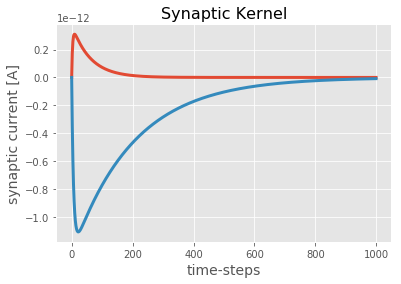

In [7]:
from core.synapse import AMPACurrentSynapse, GABAACurrentSynapse

# alternative parameters fitted with Synaptic_Kernel_Comparison.ipynb
t_d_e = 6e-3
t_r_e = 3e-4
t_r_i = 6e-4

# instantiate an excitatory and an inhibitory synapse
synapse_e = AMPACurrentSynapse(bin_size=1e-4, max_delay=0.1, tau_decay=t_d_e, tau_rise=t_r_e)
synapse_i = GABAACurrentSynapse(bin_size=1e-4, max_delay=0.1, tau_rise=t_r_i)

# print default parameters (can be changed during initialization)
print('Default synaptic efficacies (He/Hi): ', [synapse_e.efficacy, synapse_i.efficacy], ' A.')
print('Default synaptic rise times: ', [synapse_e.kernel_function_args['tau_rise'], synapse_i.kernel_function_args['tau_rise']], ' s.')
print('Default synaptic decay times: ', [synapse_e.kernel_function_args['tau_decay'], synapse_i.kernel_function_args['tau_decay']], ' s.')

# plot synaptic kernels
fig, axes = plt.subplots()
axes = synapse_e.plot_synaptic_kernel(create_plot=False, axes=axes)
axes = synapse_i.plot_synaptic_kernel(create_plot=False, axes=axes)

Text(0.5,1,'IINs')

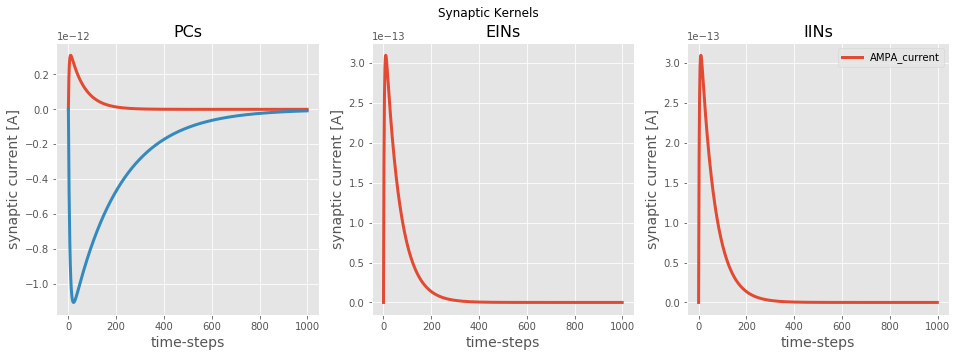

In [8]:
from core.circuit import JansenRitLeakyCapacitorCircuit

# include alternative synapse parameters
synapse_params_e = {'tau_rise': t_r_e, 'tau_decay': t_d_e}
synapse_params_i = {'tau_rise': t_r_i}

# instantiate circuit
jrc = JansenRitLeakyCapacitorCircuit(step_size=1e-4, max_synaptic_delay=0.1, 
                                     synapse_params=[synapse_params_e, synapse_params_i])

# plot synaptic kernels of each population
fig, axes = plt.subplots(1,3, figsize=(16,5))
plt.suptitle('Synaptic Kernels')
ax1 = axes[0]
ax1 = jrc.populations[0].plot_synaptic_kernels(create_plot=False, axes=ax1)
ax1.set_title('PCs')
ax2 = axes[1]
ax2 = jrc.populations[1].plot_synaptic_kernels(create_plot=False, axes=ax2)
ax2.set_title('EINs')
ax3 = axes[2]
ax3 = jrc.populations[2].plot_synaptic_kernels(create_plot=False, axes=ax3)
ax3.set_title('IINs')

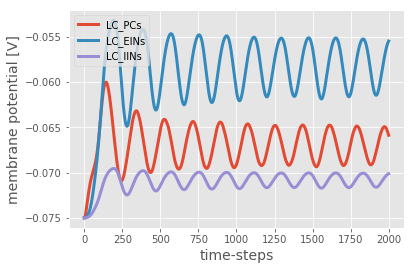

In [9]:
from core.circuit import JansenRitLeakyCapacitorCircuit

# instantiate circuit
jrc = JansenRitLeakyCapacitorCircuit(step_size=5e-4, max_synaptic_delay=0.5, 
                                     synapse_params=[synapse_params_e, synapse_params_i])

# define input to circuit
synaptic_input = np.zeros((2000, 3, 2))                      # 2000 time-steps (1 s) x 3 populations x 2 synapses
synaptic_input[:, 0, 0] = 22 * np.random.randn(2000) + 220   # gaussian input to PCs
simulation_time = 1.                                         # 1 s simulation duration

# simulate circuit behavior
jrc.run(simulation_time=simulation_time, synaptic_inputs=synaptic_input)

# plot resulting membrane potential traces
fig, axes = plt.subplots()
axes = jrc.plot_population_states(create_plot=False, axes=axes)

In [10]:
from core.circuit import JansenRitLeakyCapacitorCircuit

# circuit parameters
step_size = 5e-4
max_synaptic_delay = 0.5
n_populations = 3
n_synapses = 2

# define experimental conditions
C = [68., 128., 135., 270., 675., 1350.]
simulation_time = 2.5                                                 # 0.5 additional cut-off seconds 
time_steps = int(simulation_time / step_size)
synaptic_input = np.zeros((time_steps, n_populations, n_synapses))                        
synaptic_input[:, 0, 0] = np.random.uniform(120, 320, time_steps)    # input to PCs

# perform experiment for each condition

pc_state_coll = list()                                               # used to collect the membrane potential of the PCs

for c in C:
    
    # instantiate circuit
    jrc = JansenRitLeakyCapacitorCircuit(step_size=step_size, max_synaptic_delay=max_synaptic_delay, 
                                         synapse_params=[synapse_params_e, synapse_params_i], connectivity_scaling=c)
    
    # perform experiment
    jrc.run(synaptic_inputs=synaptic_input, simulation_time=simulation_time)
    
    # collect PC membrane potentials
    pc_state_coll.append(np.squeeze(jrc.get_population_states(0, [0], time_window=[0.5, simulation_time])))

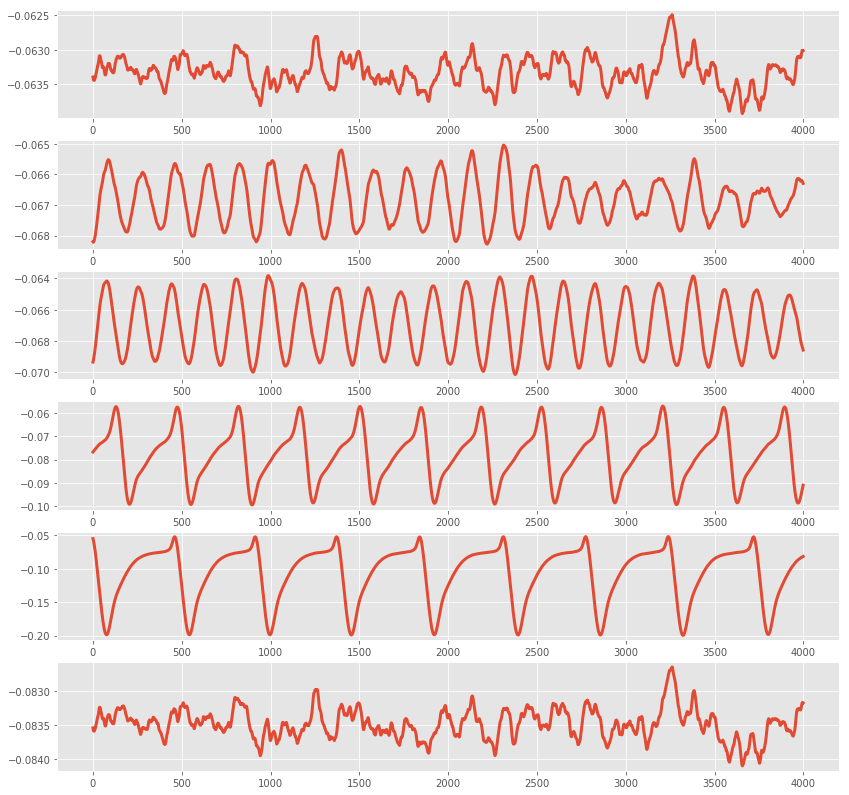

In [11]:
# plot results
fig, axes = plt.subplots(6, 1, figsize=(14, 14))

for i in range(len(pc_state_coll)):
    axes[i].plot(pc_state_coll[i])

In [12]:
from core.circuit import JansenRitLeakyCapacitorCircuit

# parameters
############

step_size = 5e-4
max_synaptic_delay = 0.5
c = 135.

# axon params
axon_params = {'membrane_potential_threshold': -0.069}
axon_params = [axon_params for i in range(3)]

# synaptic parameters
synapse_params = [synapse_params_e, synapse_params_i]

# define experimental conditions
simulation_time = 2.5                                                # 0.5 additional cut-off seconds 
time_steps = int(simulation_time / step_size)

synaptic_input = np.zeros((time_steps, n_populations, n_synapses))                        
synaptic_input[:, 0, 0] = np.random.uniform(120, 320, time_steps)    # input to PCs

exc_syn_eff = np.array([3.1, 4.5, 6.1, 8.1, 3.82]) * 1e-13
inh_syn_eff = np.array([10.03, 10.03, 10.03, 30.03, 110.]) * 1e-13

# perform experiment for each condition
pc_state_coll = list()                                               # used to collect the membrane potential of the PCs
conditions = list()

for H_e, H_i in zip(exc_syn_eff, inh_syn_eff):
        
    # set synaptic efficacies
    synapse_params[0]['efficacy'] = H_e
    synapse_params[1]['efficacy'] = -H_i

    jrc = JansenRitLeakyCapacitorCircuit(step_size=step_size, max_synaptic_delay=max_synaptic_delay, 
                                         connectivity_scaling=c, synapse_params=synapse_params, axon_params=axon_params)

    # perform experiment
    jrc.run(synaptic_inputs=synaptic_input, simulation_time=simulation_time)

    # collect PC membrane potentials and condition
    pc_state_coll.append(np.squeeze(jrc.get_population_states(0, [0], time_window=[0.5, simulation_time])))
    conditions.append([H_e, H_i])

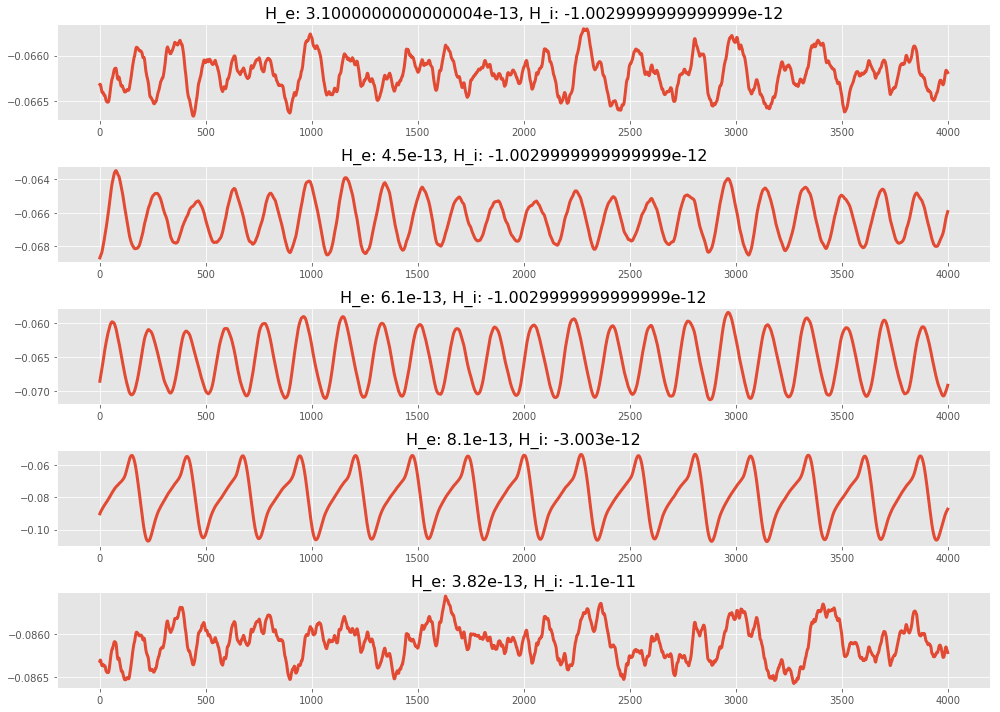

In [13]:
# plot results
fig, axes = plt.subplots(len(pc_state_coll), 1, figsize=(14, 10))

for i in range(len(pc_state_coll)):
    axes[i].plot(pc_state_coll[i])
    axes[i].set_title('H_e: ' + str(conditions[i][0]) + ', H_i: ' + str(-conditions[i][1]))

plt.tight_layout()

In [15]:
from core.circuit import CircuitFromCircuit

# synapse parametrization
synapse_params[0]['efficacy'] = 3.819e-13
synapse_params[1]['efficacy'] = -1.273e-12 

# experimental conditions
k1_col = np.array([10., 20., 60., 120.])
k2_col = np.array([10., 20., 60., 120.])
connectivity = np.zeros((2, 2, 2))
delays = np.zeros((2, 2))
synaptic_input = np.zeros((time_steps, 6, 2))
synaptic_input[:, 0, 0] = np.random.uniform(120, 320, time_steps)
synaptic_input[:, 3, 0] = np.random.uniform(120, 320, time_steps)

# circuits
jrc1 = JansenRitLeakyCapacitorCircuit(step_size=step_size, max_synaptic_delay=max_synaptic_delay, 
                                      synapse_params=synapse_params)
jrc2 = JansenRitLeakyCapacitorCircuit(step_size=step_size, max_synaptic_delay=max_synaptic_delay, 
                                      synapse_params=synapse_params)

# perform experiments:
pc_state_col = list()
conditions = list()

for k1, k2 in zip(k1_col, k2_col):
        
    # build connectivity matrix
    connectivity[0, 1, 0] = k1
    connectivity[1, 0, 0] = k2

    # connect circuits
    jrc_comb = CircuitFromCircuit([jrc1, jrc2], connectivity, delays)

    # run combined circuit
    jrc_comb.run(synaptic_input, simulation_time)

    # collect run information
    pc_state_col.append(np.squeeze(jrc_comb.get_population_states(0, [0, 3], time_window=[0.5, simulation_time])))
    conditions.append([k1, k2])

    jrc1.clear()
    jrc2.clear()

TypeError: __init__() missing 1 required positional argument: 'target_populations'

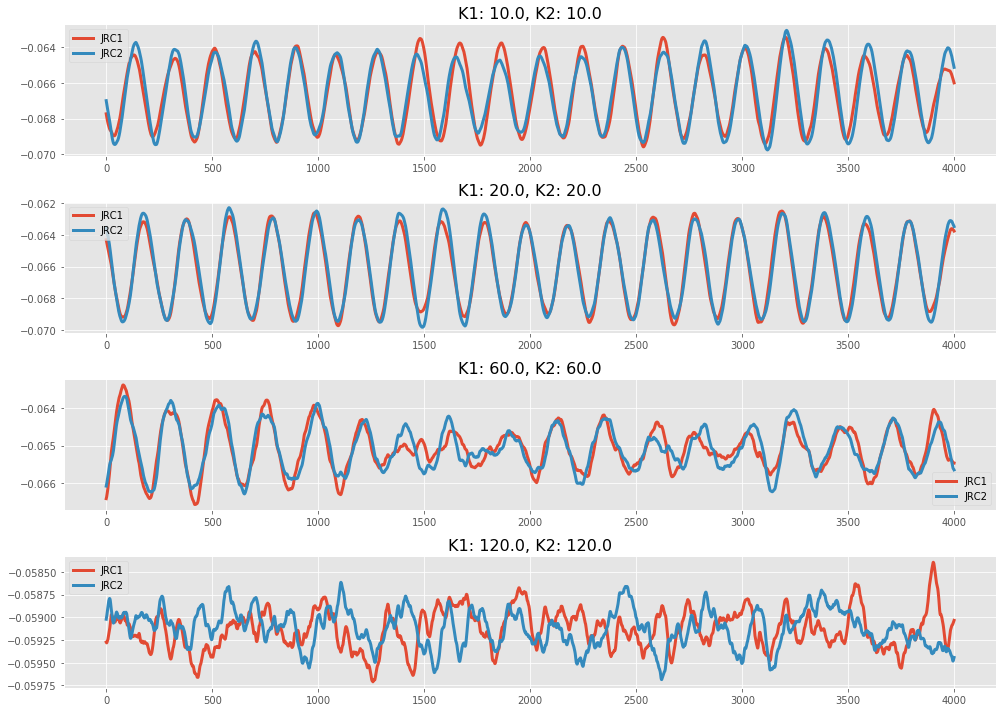

In [23]:
# plot results
fig, axes = plt.subplots(len(pc_state_col), 1, figsize=(14, 10))

for i in range(len(pc_state_col)):
    axes[i].plot(pc_state_col[i])
    axes[i].set_title('K1: ' + str(conditions[i][0]) + ', K2: ' + str(conditions[i][1]))
    axes[i].legend(['JRC1', 'JRC2'])

plt.tight_layout()

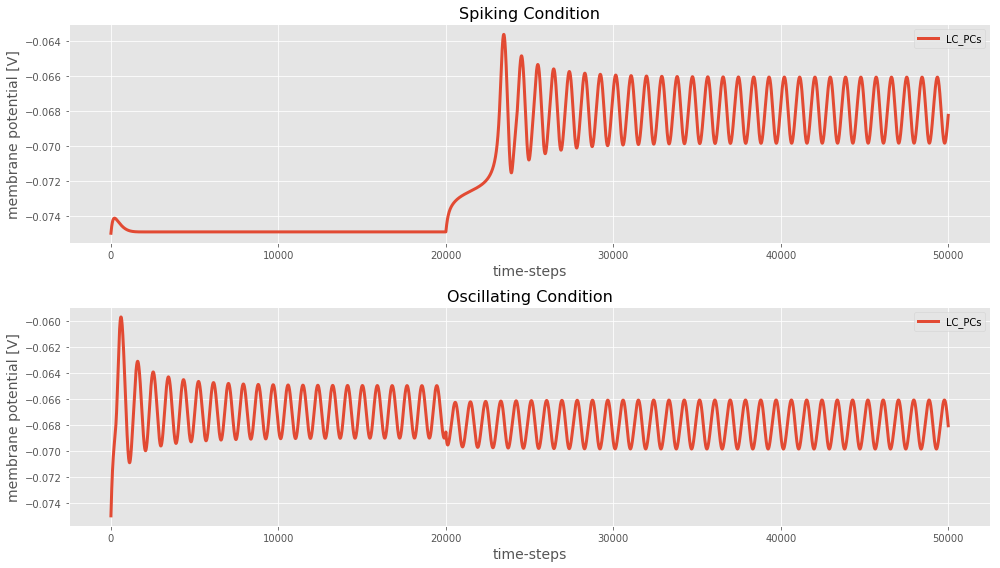

In [45]:
from core.circuit import JansenRitLeakyCapacitorCircuit

# define parameters and conditions
##################################

# circuit parameters
step_size = 1e-4
max_synaptic_delay = 0.5
init_states = np.zeros(3) - 0.075

# simulation parameters
simulation_time = 5.
cutoff_time = 2.
simulation_steps = int(simulation_time / step_size)
cutoff_steps = int(cutoff_time / step_size)

# input
synaptic_input = np.zeros((simulation_steps, 3, 2))
extrinsic_current = np.zeros((simulation_steps, 3))
extrinsic_current[cutoff_steps:simulation_steps, 0] = 2e-13

# instantiate circuit, run experiments and plot results
#######################################################

# plot preparation
fig, axes = plt.subplots(2, 1, figsize=(14,8))

# instantiation
jrc = JansenRitLeakyCapacitorCircuit(step_size=step_size, max_synaptic_delay=max_synaptic_delay, 
                                     init_states=init_states, synapse_params=synapse_params)

# experiment 1
extrinsic_current[:cutoff_steps, 0] = 1e-13
jrc.run(synaptic_input, simulation_time, extrinsic_current=extrinsic_current)
axes[0] = jrc.plot_population_states([0], time_window=[0., simulation_time], create_plot=False, axes=axes[0])
axes[0].set_title('Spiking Condition')

jrc.clear()

# experiment 2
extrinsic_current[:cutoff_steps, 0] = 5e-13
jrc.run(synaptic_input, simulation_time, extrinsic_current=extrinsic_current)
axes[1] = jrc.plot_population_states([0], time_window=[0., simulation_time], create_plot=False, axes=axes[1])
axes[1].set_title('Oscillating Condition')

plt.tight_layout()

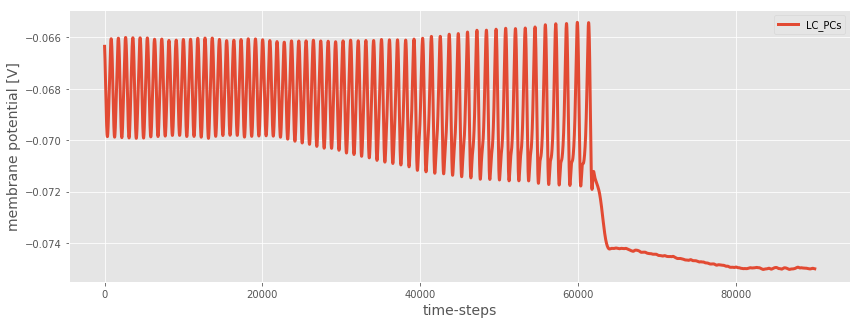

In [38]:
from core.circuit import JansenRitLeakyCapacitorCircuit

# define parameters and conditions
##################################

# circuit parameters
step_size = 1e-4
max_synaptic_delay = 0.5
init_states = np.zeros(3) - 0.075

# simulation parameters
simulation_time = 10.
change_time = 2.
cutoff_time = 1.
simulation_steps = int(simulation_time / step_size)
change_steps = int(change_time / step_size)
cutoff_steps = int(cutoff_time / step_size)

# input conditions
iin_input = np.array([0., 3., 3., 6., 6.]) * 1e-14
synaptic_input = np.zeros((simulation_steps, 3, 2))
extrinsic_current = np.zeros((simulation_steps, 3))
extrinsic_current[:, 0] = np.random.normal(2e-13, 3e-14, simulation_steps)
extrinsic_current[:, 0] = gaussian_filter(extrinsic_current[:, 0], sigma=100.)

for i in range(len(iin_input)):
    if not (i % 2 == 1):
        extrinsic_current[cutoff_steps+i*change_steps:cutoff_steps+(i+1)*change_steps, 2] = iin_input[i]
    else:
        extrinsic_current[cutoff_steps+i*change_steps:cutoff_steps+(i+1)*change_steps, 2] = np.linspace(iin_input[i-1], iin_input[i], change_steps)

# instantiate circuit, run experiment and plot results
######################################################

# plot preparation
fig, axes = plt.subplots(figsize=(14,5))

# instantiation
jrc = JansenRitLeakyCapacitorCircuit(step_size=step_size, max_synaptic_delay=max_synaptic_delay, 
                                     init_states=init_states, synapse_params=synapse_params)

# experiment
jrc.run(synaptic_input, simulation_time, extrinsic_current=extrinsic_current)
axes = jrc.plot_population_states([0], time_window=[cutoff_time, simulation_time], create_plot=False, axes=axes)